In [1]:
# imports
import numpy as np
import qp
import qit
from scipy.optimize import minimize
%matplotlib inline

# True distribution

First, we make a true distribution.  For this simple example, it is just a Gaussian

We are going to be calling this $p^{\dagger}(z_{\rm true})$

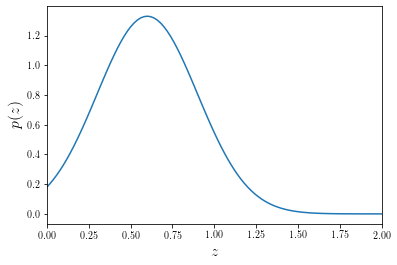

In [2]:
# true distribution of redshifts
Z_TRUE_MIN, Z_TRUE_MAX = 0., 2.
LOC_TRUE = 0.60
SCALE_TRUE = 0.30

true_dist = qp.Ensemble(qp.stats.norm, data=dict(loc=LOC_TRUE, scale=SCALE_TRUE))
ax_true = true_dist.plot(xlim=(Z_TRUE_MIN, Z_TRUE_MAX), label=r"unnorm")

# Implicit prior

Now we make the implicit prior.  In our case it is similiar to the true distribution, but slightly different.

We will call this $p^{*}(z_{\rm true})$

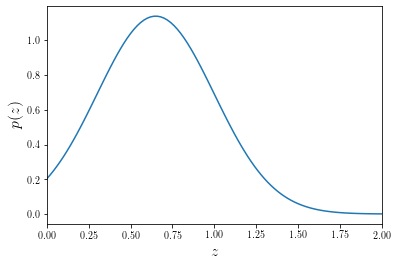

In [3]:
LOC_PRIOR = 0.65
SCALE_PRIOR = 0.35
implicit_prior = qp.Ensemble(qp.stats.norm, data=dict(loc=LOC_PRIOR, scale=SCALE_PRIOR))
ax_prior = implicit_prior.plot(xlim=(Z_TRUE_MIN, Z_TRUE_MAX), label=r"unnorm")

# Estimator

Now we try and model the behavior of a simple estimator.
Our simple estimator has a likelihood $p(d | z_{\rm true})$ to return an esimate $d$ for a true value $z_{\rm true}$.

In [4]:
# This represents the "estimator" code, we define 50 bins (in true redshift)
# and in each bin the likelihood $p(d | z_{\rm true})$ is a Gaussian centered on the bin center

N_EST_BINS = 50

z_bins = np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_EST_BINS+1)
z_centers = qp.utils.edge_to_center(z_bins)
z_widths = 0.2 * np.ones(N_EST_BINS)
likelihood = qp.Ensemble(qp.stats.norm, data=dict(loc=np.expand_dims(z_centers, -1), scale=np.expand_dims(z_widths, -1)))

In [5]:
like_estim = qit.Estimator([z_bins], likelihood)

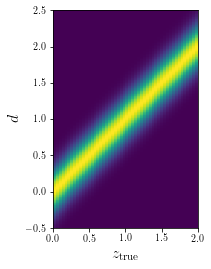

In [6]:
# These are the points at which we evaluate the PDFs
N_OBS_BINS = 300
Z_OBS_MIN, Z_OBS_MAX = -0.5, 2.5
z_obs_edge = np.linspace(Z_OBS_MIN, Z_OBS_MAX, N_OBS_BINS+1)
z_obs_cent = qp.utils.edge_to_center(z_obs_edge)
p_grid = likelihood.pdf(z_obs_cent)

plot_kwds = dict(xlabel=r'$z_{\rm true}$',
                 ylabel=r'$d$',
                 extent=(Z_TRUE_MIN, Z_TRUE_MAX, Z_OBS_MIN, Z_OBS_MAX),
                 origin='lower')
pl_like = qit.plotting.plot_2d_like(p_grid.T, **plot_kwds)

In [7]:
p_grid.shape

(50, 300)

# Posterior distributions

Ok, now we are going to extract the posterior distributions $p(z_{\rm true}|d)$, $p(z_{\rm true}|d,\phi^{\dagger})$ and $p(z_{\rm true}|d,\phi^{*})$.  In our case these correspond to the posteriors assuming a flat prior, assuming the true distribution as the prior and assuming the implicit prior.

We are going to do this twice, the first time we will use `qit.like_funcs.get_posterior_grid` the second time we will use `qit.Estimator.get_posterior_grid`

(300, 50)


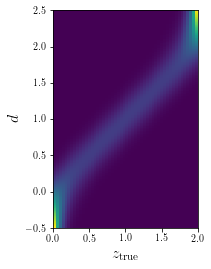

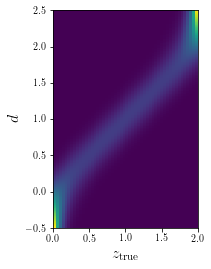

In [8]:
# Let's flip around the likelihood
z_grid = z_centers

# This should give the posterior p(z | d) for each of d bins 
flat_post = qp.Ensemble(qp.stats.hist, data=dict(bins=z_bins, pdfs=p_grid.T))

post_grid_check = flat_post.pdf(z_grid)
post_grid = qit.like_funcs.get_posterior_grid(likelihood, z_obs_cent)

pl_post_check = qit.plotting.plot_2d_like(post_grid_check, **plot_kwds)
pl_post = qit.plotting.plot_2d_like(post_grid, **plot_kwds)

(50,)
(300, 50)
(50,)
(300, 50)


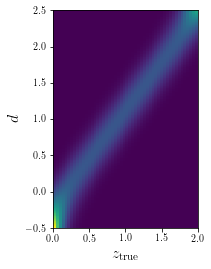

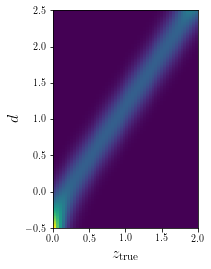

In [9]:
est_grid = qit.like_funcs.get_posterior_grid(likelihood, z_obs_cent, implicit_prior, z_grid)
true_grid = qit.like_funcs.get_posterior_grid(likelihood, z_obs_cent, true_dist, z_grid)

pl_est = qit.plotting.plot_2d_like(est_grid, **plot_kwds)
pl_true = qit.plotting.plot_2d_like(true_grid, **plot_kwds)

# Sample points from the true distribution

Here we are going to use the `qp.Ensemble.rvs` function to generate rand samples from the true distribution

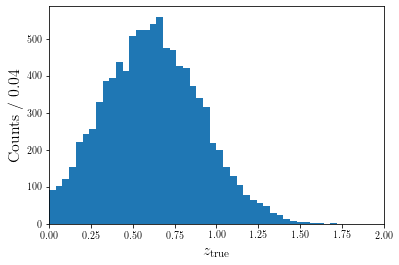

In [10]:
# Now let's sample points in true z
N_SAMPLES = 10000
N_HIST_BINS = 50
z_true_sample = np.squeeze(true_dist.rvs(size=N_SAMPLES))
fig_sample, ax_sample = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                     xlabel=r"$z_{\rm true}$",
                                                     ylabel="Counts / %0.2f" % ((Z_TRUE_MAX-Z_TRUE_MIN)/N_HIST_BINS))
hist = ax_sample.hist(z_true_sample, bins=np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_HIST_BINS+1))

# Create a sample of points in the measured distribution

We do this by sampling a $d$ value from the correct bin for each sampled value in $z_{\rm true}$.

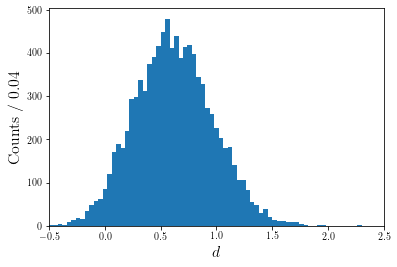

In [11]:
# Now we create a sample of points in measured z.
N_OBS_HIST_BINS = 75
whichbin = np.searchsorted(z_bins, z_true_sample)-1
mask = (z_true_sample > 0) * (z_true_sample <= 2.0)
mask *= (whichbin < z_centers.size)
whichbin = whichbin[mask]

sampler = qp.Ensemble(qp.stats.norm, data=dict(loc=np.expand_dims(z_centers[whichbin], -1), scale=np.expand_dims(z_widths[whichbin], -1)))
z_meas_sample = np.squeeze(sampler.rvs(1))

fig_hmeas, ax_hmeas = qp.plotting.make_figure_axes(xlim=(Z_OBS_MIN, Z_OBS_MAX),
                                                   xlabel=r"$d$",
                                                   ylabel="Counts / %0.2f" % ((Z_OBS_MAX-Z_OBS_MIN)/N_OBS_HIST_BINS))

hist = ax_hmeas.hist(z_meas_sample, bins=np.linspace(Z_OBS_MIN, Z_OBS_MAX, N_OBS_HIST_BINS+1))

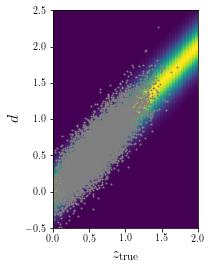

In [12]:
# Overplot the scatter plot on the 2-d likelihood plot
pl_true = qit.plotting.plot_2d_like(p_grid.T, **plot_kwds)
ax_like2 = pl_true
sc = ax_like2.scatter(z_true_sample[mask], z_meas_sample, s=1, color='gray')

# Profile plot

The previous plot is a bit messy, lets plot the mean and std in slices of x.  (This is a "profile" plot in particle physics jargon.)

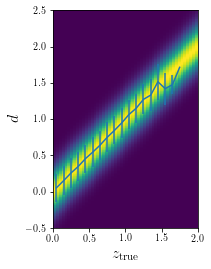

In [13]:
N_PROF_BINS = 20
pl_true2 = qit.plotting.plot_2d_like(p_grid.T, **plot_kwds)
ax_prof = pl_true2
x_prof = np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_PROF_BINS+1)
x_prof_cent = qp.utils.edge_to_center(x_prof)
prof_vals, prof_errs = qp.utils.profile(z_true_sample[mask], z_meas_sample, x_prof)
sc = ax_prof.errorbar(x_prof_cent, prof_vals, yerr=prof_errs)

# Posteriors for the measured values

Now we get $p(z|d_{j})$, $p(z | d_{j}, \phi^{\dagger})$ and $p(z | d_{j}, \phi^{*})$ for the samples we simulated.

In [14]:
# Now we get the posteriors for all the measured values
z_meas_bin = np.searchsorted(z_obs_cent, z_meas_sample)-1
z_meas_mask = (z_meas_bin >= 0) * (z_meas_bin < z_obs_cent.size)
z_meas_bin = z_meas_bin[z_meas_mask]

post_dict = qit.like_funcs.make_ensemble_for_posterior_interp(post_grid, z_grid, z_meas_bin)
est_dict = qit.like_funcs.make_ensemble_for_posterior_interp(est_grid, z_grid, z_meas_bin)
true_dict = qit.like_funcs.make_ensemble_for_posterior_interp(true_grid, z_grid, z_meas_bin)

In [15]:
z_grid

array([0.02, 0.06, 0.1 , 0.14, 0.18, 0.22, 0.26, 0.3 , 0.34, 0.38, 0.42,
       0.46, 0.5 , 0.54, 0.58, 0.62, 0.66, 0.7 , 0.74, 0.78, 0.82, 0.86,
       0.9 , 0.94, 0.98, 1.02, 1.06, 1.1 , 1.14, 1.18, 1.22, 1.26, 1.3 ,
       1.34, 1.38, 1.42, 1.46, 1.5 , 1.54, 1.58, 1.62, 1.66, 1.7 , 1.74,
       1.78, 1.82, 1.86, 1.9 , 1.94, 1.98])

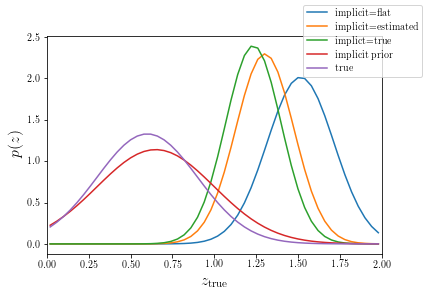

In [16]:
which_sample = np.argmax(z_meas_sample[0:100])
fig_x, ax_x = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                           xlabel=r"$z_{\rm true}$",
                                           ylabel=r"$p(z)$")
ax_x.plot(z_grid, post_dict['vals'][which_sample], label='implicit=flat')
ax_x.plot(z_grid, est_dict['vals'][which_sample], label='implicit=estimated')
ax_x.plot(z_grid, true_dict['vals'][which_sample], label='implict=true')
ax_x.plot(z_grid, np.squeeze(implicit_prior.pdf(z_grid)), label='implicit prior')
ax_x.plot(z_grid, np.squeeze(true_dist.pdf(z_grid)), label='true')
leg = fig_x.legend()

# Check of effect of binning the samples

This compares a histogram made from the original z_meas values to a histogram made by taking the closest grid point

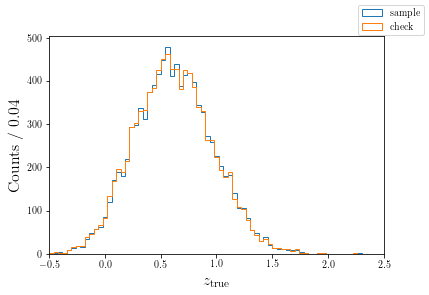

In [17]:
fig_check, ax_check = qp.plotting.make_figure_axes(xlim=(Z_OBS_MIN, Z_OBS_MAX),
                                                   xlabel=r"$z_{\rm true}$",
                                                   ylabel="Counts / %0.02f" % ((Z_OBS_MAX-Z_OBS_MIN)/N_OBS_HIST_BINS))

ax_check.hist(z_meas_sample, bins=np.linspace(Z_OBS_MIN, Z_OBS_MAX, N_OBS_HIST_BINS+1), label='sample', histtype='step')
z_meas_binned = z_obs_cent[z_meas_bin]
ax_check.hist(z_meas_binned, bins=np.linspace(Z_OBS_MIN, Z_OBS_MAX, N_OBS_HIST_BINS+1), label='check', histtype='step')
leg = fig_check.legend()

# Compare the true distribtuion to the naive "stacking"

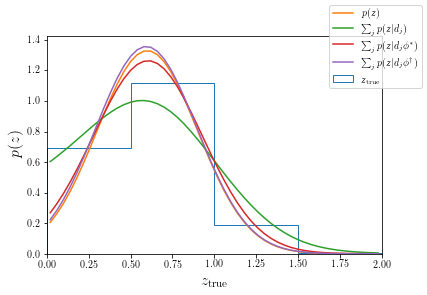

In [18]:
N_FIT_BINS = 4
hist_bins = np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_FIT_BINS+1)
fig_stack, ax_stack = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                   xlabel=r"$z_{\rm true}$",
                                                   ylabel=r"$p(z)$")
ax_stack.hist(z_true_sample[mask], bins=hist_bins, density=True, label=r'$z_{\rm true}$', histtype='step')
ax_stack.plot(z_grid, np.squeeze(true_dist.pdf(z_grid)), label=r'$p(z)$')
ax_stack.plot(z_grid, post_dict['stack'], label=r'$\sum_{j} p(z | d_{j})$')
ax_stack.plot(z_grid, est_dict['stack'], label=r'$\sum_{j} p(z | d_{j} \phi^{*})$')
ax_stack.plot(z_grid, true_dict['stack'], label=r'$\sum_{j} p(z | d_{j} \phi^{\dagger})$')
leg = fig_stack.legend()


# Plot some posterior distributions

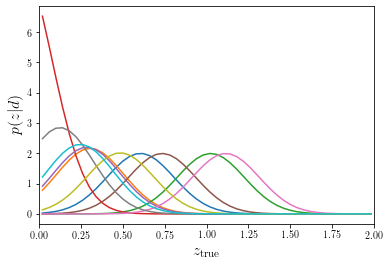

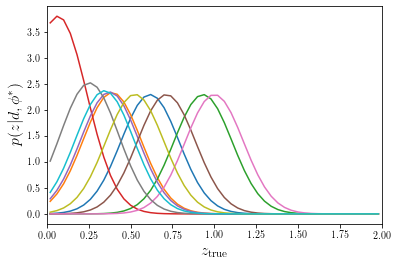

In [19]:
fig_1, ax_1 = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                   xlabel=r"$z_{\rm true}$",
                                                   ylabel=r"$p(z | d)$")
fig_2, ax_2 = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                   xlabel=r"$z_{\rm true}$",
                                                   ylabel=r"$p(z | d, \phi^{*})$")

post_vals = post_dict['vals']
est_vals = est_dict['vals']
for i in range(10):
    ax_1.plot(z_grid, post_vals[i])
    ax_2.plot(z_grid, est_vals[i])

# Test to make sure we can update the parameters of a distritubion for fitting

This is just a software test to make sure that setting the values of a model parameter changes the model.

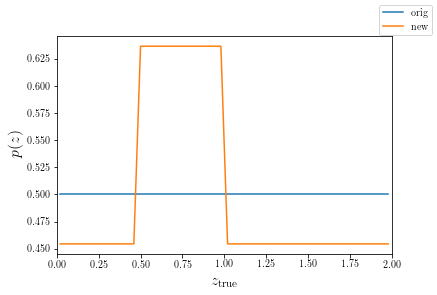

In [20]:
model_params = np.ones((1, N_FIT_BINS))
model = qp.Ensemble(qp.stats.hist, data=dict(bins=hist_bins, pdfs=model_params))
fig_model, ax_model = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                   xlabel=r"$z_{\rm true}$",
                                                   ylabel=r"$p(z)$")

ax_model.plot(z_grid, np.squeeze(model.pdf(z_grid)), label='orig')

new_params = np.ones(N_FIT_BINS)
new_params[1] = 1.4

model.update_objdata(dict(pdfs=np.expand_dims(new_params, 0)))
ax_model.plot(z_grid, np.squeeze(model.pdf(z_grid)), label='new')
leg = fig_model.legend()

# Test the likelihood function by evaluating it for a flat distribution and for the true distribution

In [21]:
N_EVAL_PTS = 201
eval_grid = np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_EVAL_PTS)
model_params = np.log(np.ones(N_FIT_BINS))
hist_cents = qp.utils.edge_to_center(hist_bins)
true_vals = np.histogram(z_true_sample, bins=np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_FIT_BINS+1))[0]
v_flat = qit.like_funcs.log_hyper_like(model_params, est_dict['ens'], model, implicit_prior, eval_grid)
v_true = qit.like_funcs.log_hyper_like(np.log(true_vals), est_dict['ens'], model, implicit_prior, eval_grid)
print(v_flat, v_true)

-85970.27394713137 -89878.23620326053


# Make the objective function for fitting

In this case it is just the log_hyper_like with all of the arguments except for the logs of the bin heights, (i.e. the fitting parameters) specified.

In [22]:
obj_func = qit.like_funcs.make_log_hyper_obj_func(ensemble=est_dict['ens'],\
                   model=model, implicit_prior=implicit_prior, grid=eval_grid)

In [23]:
v_flat = obj_func(model_params)
v_true = obj_func(np.log(true_vals))
print(v_flat, v_true)

-85970.27394713137 -89878.23620326053


# Fit for the hyper-parameters

In [24]:
result = minimize(obj_func, model_params)
print(result)

      fun: -89965.69995645904
 hess_inv: array([[0.20139666, 0.19831929, 0.20676951, 0.39966594],
       [0.19831929, 0.19632947, 0.20390311, 0.39459932],
       [0.20676951, 0.20390311, 0.21853901, 0.41062035],
       [0.39966594, 0.39459932, 0.41062035, 0.79426377]])
      jac: array([ 0.00097656, -0.00390625,  0.00195312,  0.00097656])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 205
      nit: 21
     njev: 41
   status: 2
  success: False
        x: array([ 2.03830477,  2.73740093,  0.05358946, -4.7906254 ])


In [25]:
# Check the current value of the objective function
obj_func(result['x'])

-89965.69995645904

In [26]:
# Extract the parameters and convert back to counts (The Jacobian happens to be identical to the fitted values)
fitted_vals = np.exp(result['x'])
fitted_errs = np.sqrt(np.array([result['hess_inv'][i,i] for i in range(4)]))
norm_factor = 2 / fitted_vals.sum()
normed_fit = norm_factor * fitted_vals
jac = fitted_vals
# Convert to PDF, for plotting
normed_errs = norm_factor * jac * fitted_errs
model.update_objdata(dict(pdfs=np.expand_dims(normed_fit, 0)))
model_vals = np.squeeze(model.pdf(z_grid))

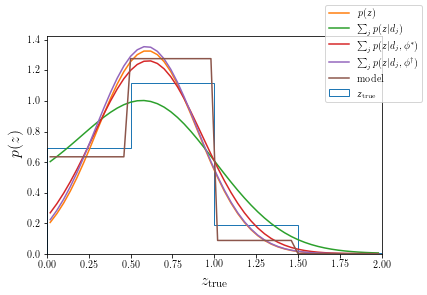

In [27]:
fig_result, ax_result = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                     xlabel=r"$z_{\rm true}$",
                                                     ylabel=r"$p(z)$")
ax_result.hist(z_true_sample[mask], bins=hist_bins, density=True, label=r'$z_{\rm true}$', histtype='step')
ax_result.plot(z_grid, np.squeeze(true_dist.pdf(z_grid)), label=r'$p(z)$')
ax_result.plot(z_grid, post_dict['stack'], label=r'$\sum_j p(z | d_{j}$)')
ax_result.plot(z_grid, est_dict['stack'], label=r'$\sum_j p(z | d_{j}, \phi^{*})$')
ax_result.plot(z_grid, true_dict['stack'], label=r'$\sum_j p(z | d_{j}, \phi^{\dagger})$')
#ax_result.errorbar(hist_cents, normed_fit, yerr=normed_errs, label="result")
ax_result.plot(z_grid, model_vals, label='model')
leg = fig_result.legend()


# Fitting in counts space

In [28]:
N_LIKE_PTS = 301
like_grid = np.linspace(Z_OBS_MIN, Z_OBS_MAX, N_LIKE_PTS)
eval_bins = np.searchsorted(z_bins, eval_grid, side='left')-1
eval_mask = (eval_bins >= 0) * (eval_bins < z_bins.size-1)
eval_grid = eval_grid[eval_mask]
eval_bins = eval_bins[eval_mask]
like_eval = likelihood.pdf(like_grid)[eval_bins]
obs_cts_grid = np.linspace(Z_OBS_MIN, Z_OBS_MAX, 7)
data_cts = np.histogram(z_meas_sample, bins=obs_cts_grid)[0]

obj_func_binned = qit.like_funcs.make_binnned_loglike_obj_func(model=model, data_cts=data_cts,\
                          like_eval=like_eval, like_grid=like_grid, model_grid=eval_grid, cts_grid=obs_cts_grid)

In [29]:
flat = 0.5*data_cts.sum()*np.ones(4)
model_flat = qit.like_funcs.model_counts(np.log(flat), model, like_eval, like_grid, eval_grid, obs_cts_grid)
model_true = qit.like_funcs.model_counts(np.log(true_vals), model, like_eval, like_grid, eval_grid, obs_cts_grid)
ll_flat = obj_func_binned(np.log(flat))
ll_true = obj_func_binned(np.log(true_vals))
print(ll_flat, ll_true)

-62201.52129252529 -68702.27737140989


In [30]:
result = minimize(obj_func_binned, np.ones(4))
print(result)

      fun: -68760.60464693044
 hess_inv: array([[ 6.81127967e-03, -5.06647746e-04, -6.79109357e-03,
        -3.52859696e-04],
       [-5.06647746e-04,  1.41665042e-04,  5.04376468e-04,
        -8.35140994e-05],
       [-6.79109357e-03,  5.04376468e-04,  6.79356441e-03,
         3.57634600e-04],
       [-3.52859696e-04, -8.35140994e-05,  3.57634600e-04,
         3.87029441e-01]])
      jac: array([ 0.        ,  0.00097656, -0.00097656,  0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 365
      nit: 32
     njev: 73
   status: 2
  success: False
        x: array([8.01933728, 8.74285761, 6.10830265, 0.91160796])


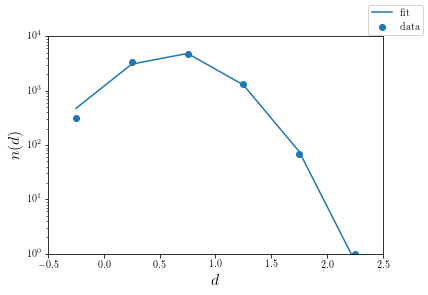

In [31]:
model_cts = qit.like_funcs.model_counts(result['x'], model, like_eval, like_grid, eval_grid, obs_cts_grid)
cts_cent = 0.5 * (obs_cts_grid[1:] + obs_cts_grid[:-1])
fig_fit, ax_fit = qp.plotting.make_figure_axes(xlim=(Z_OBS_MIN, Z_OBS_MAX),
                                                     xlabel=r"$d$",
                                                     ylabel=r"$n(d)$")
ax_fit.set_yscale('log')
ax_fit.set_ylim(1., 1e4)
ax_fit.scatter(cts_cent, data_cts, label='data')
ax_fit.plot(cts_cent, model_cts, label='fit')
leg = fig_fit.legend()

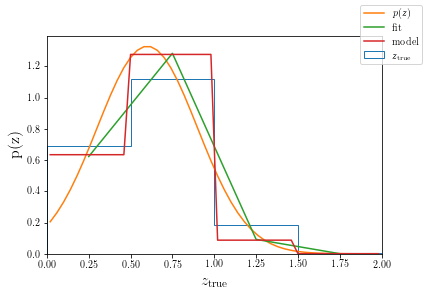

In [32]:
fit_cts = np.exp(result['x'])
fit_cts *= 2/fit_cts.sum()
pdf_true = true_vals * 2 / true_vals.sum()
fig_fit2, ax_fit2 = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                xlabel=r'$z_{\rm true}$',
                                                ylabel=r'p(z)')

ax_fit2.hist(z_true_sample[mask], bins=hist_bins, density=True, label=r'$z_{\rm true}$', histtype='step')
ax_fit2.plot(z_grid, np.squeeze(true_dist.pdf(z_grid)), label=r'$p(z)$')
ax_fit2.plot(hist_cents, fit_cts, label="fit")
ax_fit2.plot(z_grid, model_vals, label='model')
leg = fig_fit2.legend()
